In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from sklearn import mixture
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import linear_model # Scikit-Learn - https://scikit-learn.org/ 
from pandas.plotting import andrews_curves

from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error


In [3]:
#Number and Age-adjusted rates of drug overdose death by state, US 2019
overdoseByState = pd.read_csv("overdoseDeathByState.csv")

#Medicare Prescription Rate by State taken from 
# source = https://data.cms.gov/summary-statistics-on-use-and-payments/medicare-medicaid-opioid-prescribing-rates/medicare-part-d-opioid-prescribing-rates-by-geography
medicare = pd.read_csv("medicarePrescriptionRates.csv")

In [4]:
#Dropping Rows that are lower or higher scale than state
medicare = medicare[medicare['Prscrbr_Geo_Desc'].isin(overdoseByState['Location'].values)]
#RUCA_Cd is only recorded at the ZIPCODE level, so these values are not useful
medicare.drop(columns=['RUCA_Cd'])

,Year,Prscrbr_Geo_Lvl,Prscrbr_Geo_Cd,Prscrbr_Geo_Desc,Breakout_Type,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,LA_Tot_Opioid_Clms,LA_Opioid_Prscrbng_Rate,LA_Opioid_Prscrbng_Rate_5Y_Chg,LA_Opioid_Prscrbng_Rate_1Y_Chg
3,2019,State,1.0,Alabama,Totals,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.40,-0.42,138456.0,7.63,-2.13,-0.73
4,2019,State,2.0,Alaska,Totals,Overall,2847.0,1935.0,80311.0,1639104.0,4.90,-2.01,-0.90,13005.0,16.19,-3.73,-2.42
5,2019,State,4.0,Arizona,Totals,Overall,25876.0,16578.0,1359955.0,25693764.0,5.29,-1.79,-0.33,184250.0,13.55,-2.58,-1.25
6,2019,State,5.0,Arkansas,Totals,Overall,9700.0,7258.0,998319.0,17894303.0,5.58,-1.08,-0.32,76135.0,7.63,-1.69,-0.93
7,2019,State,6.0,California,Totals,Overall,129325.0,80941.0,5888034.0,138971644.0,4.24,-1.29,-0.35,630832.0,10.71,-1.32,-0.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179788,2013,State,51.0,Virginia,Rural/Urban,Urban,21921.0,17493.0,1343634.0,22061872.0,6.09,NaN,NaN,177950.5,13.24,NaN,NaN
179789,2013,State,53.0,Washington,Rural/Urban,Urban,22202.0,17452.0,1392563.0,19858703.0,7.01,NaN,NaN,255333.0,18.34,NaN,NaN
179790,2013,State,54.0,West Virginia,Rural/Urban,Urban,5084.0,4006.0,573559.0,8294087.0,6.92,NaN,NaN,55543.0,9.68,NaN,NaN
179791,2013,State,55.0,Wisconsin,Rural/Urban,Urban,15456.0,12276.0,1073521.0,17510059.0,6.13,NaN,NaN,201505.0,18.77,NaN,NaN


In [5]:
#Here I'm parsing out medicare information for the state level in just the year 2019
medicare2019 = medicare[medicare['Year']==2019]
medicare2019Overall = medicare2019[medicare2019['Breakout']=='Overall']

In [6]:
#result = medicare2019.append([overdoseByState])
horizontal_stack = pd.concat([medicare2019Overall, overdoseByState], axis=1)

In [7]:
medicare2019Overall.rename(columns = {'Prscrbr_Geo_Desc' : 'state'}, inplace = True)
overdoseByState.rename(columns = {'Location' : 'state'}, inplace = True)

/Users/jacobmitchell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
medicare2019Overall.reset_index(drop = True)
#overdoseByState.reset_index(drop = True)
#overdoseByState.drop([51]) #This only has NaN values, just drop it.

,Year,Prscrbr_Geo_Lvl,Prscrbr_Geo_Cd,state,RUCA_Cd,Breakout_Type,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,LA_Tot_Opioid_Clms,LA_Opioid_Prscrbng_Rate,LA_Opioid_Prscrbng_Rate_5Y_Chg,LA_Opioid_Prscrbng_Rate_1Y_Chg
0,2019,State,1.0,Alabama,NaN,Totals,Overall,15575.0,9739.0,1814583.0,28008206.0,6.48,-1.40,-0.42,138456.0,7.63,-2.13,-0.73
1,2019,State,2.0,Alaska,NaN,Totals,Overall,2847.0,1935.0,80311.0,1639104.0,4.90,-2.01,-0.90,13005.0,16.19,-3.73,-2.42
2,2019,State,4.0,Arizona,NaN,Totals,Overall,25876.0,16578.0,1359955.0,25693764.0,5.29,-1.79,-0.33,184250.0,13.55,-2.58,-1.25
3,2019,State,5.0,Arkansas,NaN,Totals,Overall,9700.0,7258.0,998319.0,17894303.0,5.58,-1.08,-0.32,76135.0,7.63,-1.69,-0.93
4,2019,State,6.0,California,NaN,Totals,Overall,129325.0,80941.0,5888034.0,138971644.0,4.24,-1.29,-0.35,630832.0,10.71,-1.32,-0.55
5,2019,State,8.0,Colorado,NaN,Totals,Overall,21262.0,15273.0,986823.0,17403100.0,5.67,-1.81,-0.45,130781.0,13.25,-2.56,-0.95
6,2019,State,9.0,Connecticut,NaN,Totals,Overall,18060.0,10751.0,578122.0,16874265.0,3.43,-1.17,-0.13,83186.0,14.39,-2.38,-0.53
7,2019,State,10.0,Delaware,NaN,Totals,Overall,3759.0,2535.0,181569.0,4294537.0,4.23,-2.38,-0.71,31988.0,17.62,-2.04,-1.66
8,2019,State,11.0,District of Columbia,NaN,Totals,Overall,4957.0,3070.0,75262.0,2071246.0,3.63,-0.96,-0.18,7822.0,10.39,-0.53,0.09
9,2019,State,12.0,Florida,NaN,Totals,Overall,78483.0,45389.0,4865839.0,108893059.0,4.47,-0.84,-0.36,633156.0,13.01,-0.25,-0.75


In [9]:
overdoseByState.reset_index(drop = True)
overdoseByState.drop([51]) #This only has NaN values, just drop it.

,state,Range Category,2019 Age-adjusted Rate,2019 Number of Deaths
0,Alabama,16.1 to 18.5,16.3,768.0
1,Alaska,16.1 to 18.5,17.8,132.0
2,Arizona,21.1 to 57.0,26.8,1907.0
3,Arkansas,11.1 to 13.5,13.5,388.0
4,California,13.6 to 16.0,15.0,6198.0
5,Colorado,16.1 to 18.5,18.0,1079.0
6,Connecticut,21.1 to 57.0,34.7,1214.0
7,Delaware,21.1 to 57.0,48.0,435.0
8,District of Columbia,21.1 to 57.0,43.2,311.0
9,Florida,21.1 to 57.0,25.5,5268.0


In [10]:
state_2019 = pd.merge(medicare2019Overall, overdoseByState, left_on = 'state', right_on = 'state')

In [11]:
#Get 2018 medicare data
medicare2018 = medicare[medicare['Year']==2018]
medicare2018Overall = medicare2018[medicare2018['Breakout']=='Overall']
medicare2018Overall.rename(columns = {'Prscrbr_Geo_Desc' : 'state'}, inplace = True)

/Users/jacobmitchell/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [12]:
#Get 2017 medicare data
medicare2017 = medicare[medicare['Year']==2017]
medicare2017Overall = medicare2017[medicare2017['Breakout']=='Overall']

In [13]:
#Read in the remaining data
overdoseByState2018 = pd.read_csv("overdoseDeath2018.csv")
overdoseByState2017 = pd.read_csv("overdoseDeath2017.csv")
population = pd.read_csv("statePopulations.csv")

In [14]:
medicare2018Overall.rename(columns = {'Prscrbr_Geo_Desc' : 'state'}, inplace = True)
medicare2017Overall.rename(columns = {'Prscrbr_Geo_Desc' : 'state'}, inplace = True)
medicare2018Overall.reset_index(drop = True)
medicare2017Overall.reset_index(drop = True)

,Year,Prscrbr_Geo_Lvl,Prscrbr_Geo_Cd,state,RUCA_Cd,Breakout_Type,Breakout,Tot_Prscrbrs,Tot_Opioid_Prscrbrs,Tot_Opioid_Clms,Tot_Clms,Opioid_Prscrbng_Rate,Opioid_Prscrbng_Rate_5Y_Chg,Opioid_Prscrbng_Rate_1Y_Chg,LA_Tot_Opioid_Clms,LA_Opioid_Prscrbng_Rate,LA_Opioid_Prscrbng_Rate_5Y_Chg,LA_Opioid_Prscrbng_Rate_1Y_Chg
0,2017,State,1.0,Alabama,NaN,Totals,Overall,14415.0,9932.0,2051853.0,28457799.0,7.21,NaN,-0.26,191462.0,9.33,NaN,-0.63
1,2017,State,2.0,Alaska,NaN,Totals,Overall,2461.0,1831.0,78398.0,1227513.0,6.39,NaN,-0.55,15157.0,19.33,NaN,0.04
2,2017,State,4.0,Arizona,NaN,Totals,Overall,22950.0,17110.0,1552551.0,25057852.0,6.20,NaN,-0.39,244929.0,15.78,NaN,-0.58
3,2017,State,5.0,Arkansas,NaN,Totals,Overall,8989.0,7079.0,1130357.0,18228050.0,6.20,NaN,-0.19,107547.0,9.51,NaN,-0.29
4,2017,State,6.0,California,NaN,Totals,Overall,119832.0,83794.0,6809889.0,139049933.0,4.90,NaN,-0.17,807153.0,11.85,NaN,-0.52
5,2017,State,8.0,Colorado,NaN,Totals,Overall,20053.0,15291.0,1127939.0,16928325.0,6.66,NaN,-0.45,171282.0,15.19,NaN,-0.77
6,2017,State,9.0,Connecticut,NaN,Totals,Overall,17452.0,11657.0,641082.0,16625633.0,3.86,NaN,-0.28,102513.0,15.99,NaN,-0.76
7,2017,State,10.0,Delaware,NaN,Totals,Overall,3525.0,2612.0,222382.0,4049166.0,5.49,NaN,-0.52,43674.0,19.64,NaN,0.52
8,2017,State,11.0,District of Columbia,NaN,Totals,Overall,4806.0,3189.0,80911.0,2050753.0,3.95,NaN,-0.28,8081.0,9.99,NaN,-0.68
9,2017,State,12.0,Florida,NaN,Totals,Overall,70945.0,44994.0,5563661.0,107515188.0,5.17,NaN,-0.04,775968.0,13.95,NaN,-0.32


In [15]:
state_2018 = pd.merge(medicare2018Overall, overdoseByState2018, left_on = 'state', right_on = 'state')
state_2017 = pd.merge(medicare2017Overall, overdoseByState2017, left_on = 'state', right_on = 'state')

#For now, we don't need the totals. We just want the populations per state. This also drops Puerto Rico. We don't have that information
#from the other data sets.
population_states = population.iloc[5:55,0:]
population_states.drop([13])
population_states.reset_index(drop = True)

,Location,Census,Estimates Base,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Alabama,"4,779,736","4,780,125","4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525","4,874,486","4,887,681","4,903,185"
1,Alaska,"710,231","710,249","713,910","722,128","730,443","737,068","736,283","737,498","741,456","739,700","735,139","731,545"
2,Arizona,"6,392,017","6,392,288","6,407,172","6,472,643","6,554,978","6,632,764","6,730,413","6,829,676","6,941,072","7,044,008","7,158,024","7,278,717"
3,Arkansas,"2,915,918","2,916,031","2,921,964","2,940,667","2,952,164","2,959,400","2,967,392","2,978,048","2,989,918","3,001,345","3,009,733","3,017,804"
4,California,"37,253,956","37,254,519","37,319,502","37,638,369","37,948,800","38,260,787","38,596,972","38,918,045","39,167,117","39,358,497","39,461,588","39,512,223"
5,Colorado,"5,029,196","5,029,319","5,047,349","5,121,108","5,192,647","5,269,035","5,350,101","5,450,623","5,539,215","5,611,885","5,691,287","5,758,736"
6,Connecticut,"3,574,097","3,574,147","3,579,114","3,588,283","3,594,547","3,594,841","3,594,524","3,587,122","3,578,141","3,573,297","3,571,520","3,565,287"
7,Delaware,"897,934","897,937","899,593","907,381","915,179","923,576","932,487","941,252","948,921","956,823","965,479","973,764"
8,District of Columbia,"601,723","601,767","605,226","619,800","634,924","650,581","662,328","675,400","685,815","694,906","701,547","705,749"
9,Florida,"18,801,310","18,804,564","18,845,537","19,053,237","19,297,822","19,545,621","19,845,911","20,209,042","20,613,477","20,963,613","21,244,317","21,477,737"


In [16]:
#MORE DATA CLEANING and REG

stats_by_pop_2017 = {} #this is in alphabetical order

#Was having a lot of trouble trying to iterate through the dataframe. Instead, I pulled our the series that we want.
#It is a little easier with this.
pop_2017 = population_states['2017']
deaths_2017 = state_2017['2017_num_deaths']
LAprs_2017 = state_2017['LA_Tot_Opioid_Clms']
state_list = state_2017['state']

Tot_Opioid_Clms = state_2017['Tot_Opioid_Clms']

In [17]:
#Set the state names as the key for this dictionary
for row in state_list:
    state = row
    stats_by_pop_2017[state] = {} #creating dict inside dict

In [18]:
#Get deaths normalized by pop

normalized_deaths = [] 
size_A = pop_2017.size

#I think we need to get the comma out of our numbers so they're more workable
#I tried your usual str -> int conversion int(pop), but there was an error
#that had something to do with the base of the number, base 2, 10 etc.
#It only really worked when I removed the commas from the strings
for x in range(size_A):
    pop = pop_2017.iloc[x]
    pop = int(pop.replace(',',''))
    deaths = deaths_2017.iloc[x]
    deaths = int(deaths.replace(',',''))
    stat = (deaths/pop) * 100000 #multiplied by large integer so we are not dealing with super small vals like 0.0003
    normalized_deaths.append(stat)


In [19]:
#Get Long-Acting Claims Normalized by pop

normalized_LA_pres = []
size_A = pop_2017.size

#Same as above but for a different stat
for x in range(size_A):
    pop = pop_2017.iloc[x]
    pop = int(pop.replace(',',''))
    pres = LAprs_2017.iloc[x]
    #pres = int(pres.replace(',',''))
    stat = (pres/pop) * 100000 
    normalized_LA_pres.append(stat)

In [20]:
normalized_Tot_Opioid = []
size_A = pop_2017.size

#Same as above but for a different stat
for x in range(size_A):
    pop = pop_2017.iloc[x]
    pop = int(pop.replace(',',''))
    pres = Tot_Opioid_Clms.iloc[x]
    #pres = int(pres.replace(',',''))
    stat = (pres/pop) * 100000 
    normalized_Tot_Opioid.append(stat)

In [21]:
#Read in the stats for each state. This is a dict inside of a dict
count = 0
for row in state_list:
    state = row
    #added _ to names below
    stats_by_pop_2017[state] = {'Normalized_Death_Rate' : [normalized_deaths[count]], 'Normalized_Long-Acting_Rate' : [normalized_LA_pres[count]], 'Normalized_Tot_Opioid_Clms' : [normalized_Tot_Opioid[count]]}
    count += 1


In [22]:
norm_stats = pd.DataFrame
frames = []
for row in state_list:
    df = pd.DataFrame.from_dict(stats_by_pop_2017[row])
    frames.append(df)

norm_stats = pd.concat(frames, sort = False)

norm_stats.reset_index(drop = True)

,Normalized_Death_Rate,Normalized_Long-Acting_Rate,Normalized_Tot_Opioid_Clms
0,17.130011,3927.839776,42093.730498
1,19.872921,2049.073949,10598.621063
2,21.748982,3477.125523,22040.733060
3,14.860004,3583.293490,37661.681679
4,12.368358,2050.771908,17302.207958
5,18.086614,3052.129543,20099.111083
6,30.000305,2868.863126,17940.910034
7,35.325238,4564.480578,23241.707191
8,732.185360,111665.174858,800635.049920
9,7.331751,1414.164629,13278.989647


In [23]:
norm_stats.index = state_list
state_2017 = pd.merge(state_2017, norm_stats, on='state')
state_2017.index = state_list

In [24]:
#Doing process again for 2018

In [25]:
stats_by_pop_2018 = {} #this is in alphabetical order

#Was having a lot of trouble trying to iterate through the dataframe. Instead, I pulled our the series that we want.
#It is a little easier with this.
pop_2018 = population_states['2018']
deaths_2018 = state_2018['2018_num_deaths']
LAprs_2018 = state_2018['LA_Tot_Opioid_Clms']
state_list = state_2018['state']

Tot_Opioid_Clms = state_2018['Tot_Opioid_Clms']

In [26]:
#Set the state names as the key for this dictionary
for row in state_list:
    state = row
    stats_by_pop_2018[state] = {} #creating dict inside dict

In [27]:
normalized_deaths2018 = [] 
size_B = pop_2018.size

#I think we need to get the comma out of our numbers so they're more workable
#I tried your usual str -> int conversion int(pop), but there was an error
#that had something to do with the base of the number, base 2, 10 etc.
#It only really worked when I removed the commas from the strings
for x in range(size_B):
    pop = pop_2018.iloc[x]
    pop = int(pop.replace(',',''))
    deaths = deaths_2018.iloc[x]
    deaths = int(deaths.replace(',',''))
    stat = (deaths/pop) * 100000 #multiplied by large integer so we are not dealing with super small vals like 0.0003
    normalized_deaths2018.append(stat)


In [28]:
normalized_LA_pres2018 = []
size_B = pop_2018.size

#Same as above but for a different stat
for x in range(size_B):
    pop = pop_2018.iloc[x]
    pop = int(pop.replace(',',''))
    pres = LAprs_2018.iloc[x]
    #pres = int(pres.replace(',',''))
    stat = (pres/pop) * 100000 
    normalized_LA_pres2018.append(stat)

In [29]:
normalized_Tot_Opioid = []
size_A = pop_2017.size

#Same as above but for a different stat
for x in range(size_A):
    pop = pop_2017.iloc[x]
    pop = int(pop.replace(',',''))
    pres = Tot_Opioid_Clms.iloc[x]
    #pres = int(pres.replace(',',''))
    stat = (pres/pop) * 100000 
    normalized_Tot_Opioid.append(stat)

In [30]:
#Read in the stats for each state. This is a dict inside of a dict
count = 0
for row in state_list:
    state = row
    stats_by_pop_2018[state] = {'Normalized_Death_Rate' : [normalized_deaths2018[count]], 'Normalized_Long-Acting_Rate' : [normalized_LA_pres2018[count]], 'Normalized_Tot_Opioid_Clms' : [normalized_Tot_Opioid[count]]}
    count += 1

In [31]:
norm_stats2018 = pd.DataFrame
frames = []
for row in state_list:
    df = pd.DataFrame.from_dict(stats_by_pop_2018[row])
    frames.append(df)
    
norm_stats2018 = pd.concat(frames, sort = False)

norm_stats2018.reset_index(drop = True)

,Normalized_Death_Rate,Normalized_Long-Acting_Rate,Normalized_Tot_Opioid_Clms
0,15.856190,3315.744215,39772.542172
1,14.963157,1825.097022,9744.626200
2,23.330461,2938.590315,20176.623877
3,14.752139,3029.072679,35485.890492
4,13.552420,1826.373536,16258.750938
5,17.482865,2620.655047,18714.496110
6,29.931234,2501.931951,16765.636889
7,41.533788,4136.910280,21651.548928
8,669.662902,101398.623328,744095.316489
9,6.608826,1300.644309,12616.966360


In [32]:
norm_stats2018.index = state_list
state_2018 = pd.merge(state_2018, norm_stats2018, on='state')
state_2018.index = state_list

<AxesSubplot:>

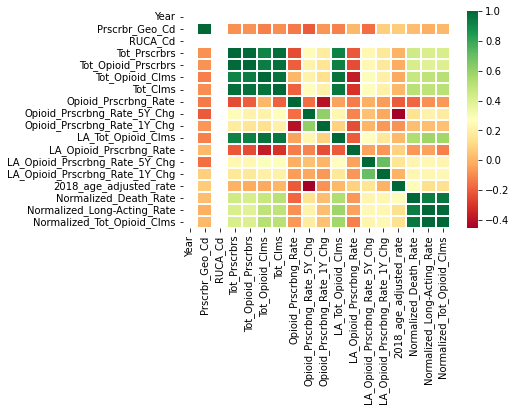

In [33]:
sns.heatmap(state_2018.corr(), cmap ='RdYlGn', linewidths = 0.30, annot = False)

In [34]:

lr = linear_model.LinearRegression()
predicted = lr.fit(X=state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), y=state_2018['Normalized_Death_Rate'].values.reshape(-1, 1))

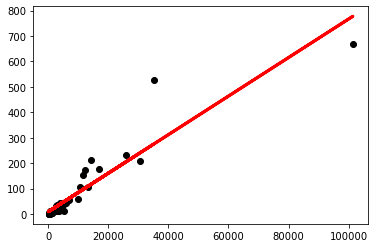

In [35]:
plt.scatter(state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), state_2018['Normalized_Death_Rate'].values.reshape(-1, 1),color='black')
predic = predicted.predict(state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1))
plt.plot(state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), predic, color = 'red', linewidth = 3)

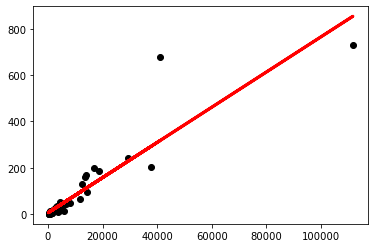

In [36]:
lr = linear_model.LinearRegression()
predicted = lr.fit(X=state_2017['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), y=state_2017['Normalized_Death_Rate'].values.reshape(-1, 1))

plt.scatter(state_2017['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), state_2017['Normalized_Death_Rate'].values.reshape(-1, 1),color='black')
predic = predicted.predict(state_2017['Normalized_Long-Acting_Rate'].values.reshape(-1, 1))
plt.plot(state_2017['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), predic, color = 'red', linewidth = 3)

/Users/jacobmitchell/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


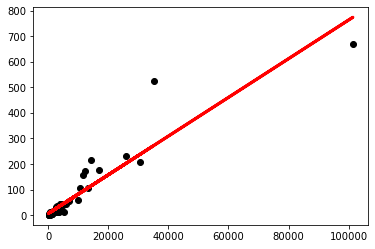

In [37]:
bay = linear_model.BayesianRidge()
predicted = bay.fit(X=state_2017['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), y=state_2017['Normalized_Death_Rate'].values.reshape(-1, 1))

plt.scatter(state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), state_2018['Normalized_Death_Rate'].values.reshape(-1, 1),color='black')
predic = predicted.predict(state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1))
plt.plot(state_2018['Normalized_Long-Acting_Rate'].values.reshape(-1, 1), predic, color = 'red', linewidth = 3)

In [38]:
MAE = mean_absolute_error(state_2018['Normalized_Death_Rate'],predic)
MSE = mean_squared_error(state_2018['Normalized_Death_Rate'],predic)
R2 = r2_score(state_2018['Normalized_Death_Rate'],predic)

In [39]:
print(MAE)

21.476606369855634


In [40]:
print(MSE)

2059.5991798722466


In [41]:
print(R2)

0.8687038966487528


/Users/jacobmitchell/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


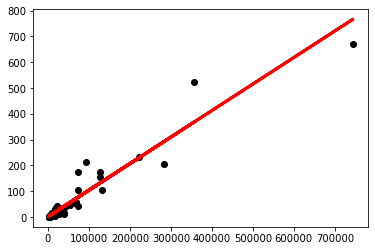

In [42]:
bay = linear_model.BayesianRidge()
predicted = bay.fit(X=state_2017['Normalized_Tot_Opioid_Clms'].values.reshape(-1, 1), y=state_2017['Normalized_Death_Rate'].values.reshape(-1, 1))

plt.scatter(state_2018['Normalized_Tot_Opioid_Clms'].values.reshape(-1, 1), state_2018['Normalized_Death_Rate'].values.reshape(-1, 1),color='black')
predic = predicted.predict(state_2018['Normalized_Tot_Opioid_Clms'].values.reshape(-1, 1))
plt.plot(state_2018['Normalized_Tot_Opioid_Clms'].values.reshape(-1, 1), predic, color = 'red', linewidth = 3)

In [43]:
MAE = mean_absolute_error(state_2018['Normalized_Death_Rate'],predic)
MSE = mean_squared_error(state_2018['Normalized_Death_Rate'],predic)
R2 = r2_score(state_2018['Normalized_Death_Rate'],predic)

In [44]:
print(MAE)

20.523531756389183


In [45]:
print(MSE)

1480.4535238365427


In [46]:
print(R2)

0.9056234918075575


# Clustering Data for 2018 Normalized Stats

In [47]:
kmeans = KMeans(n_clusters=3).fit(norm_stats2018.values)
print(kmeans, "\n")

KMeans(n_clusters=3) 



In [48]:
print(np.unique(kmeans.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([46,  1,  3]))


In [49]:
print(kmeans.cluster_centers_)

[[3.52470782e+01 3.87708342e+03 3.16229714e+04]
 [6.69662902e+02 1.01398623e+05 7.44095316e+05]
 [3.21464942e+02 3.06366644e+04 2.87947559e+05]]


In [50]:
kmeans_3 = pd.DataFrame(kmeans.labels_, columns=['cluster'])
print(kmeans_3)

    cluster
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         1
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
20        0
21        0
22        0
23        0
24        0
25        0
26        0
27        0
28        0
29        0
30        0
31        0
32        0
33        0
34        2
35        0
36        0
37        0
38        0
39        0
40        0
41        2
42        0
43        0
44        0
45        2
46        0
47        0
48        0
49        0


In [51]:
pca = PCA(n_components=2).fit(norm_stats2018)

# Perform the transform
pca_trans = pca.transform(norm_stats2018)

pca_trans_df = pd.DataFrame(pca_trans, columns=['pca1', 'pca2'])

# Add it to dataframe
kmeans_3 = pd.concat([kmeans_3, pca_trans_df], axis=1)
kmeans_3.sample(5)

,cluster,pca1,pca2
19,0,11921.128831,-3211.338801
33,0,-60358.433975,-338.294051
25,0,-57561.522521,-398.842228
44,0,-57848.813482,-629.506865
1,0,-51803.724135,-908.199755


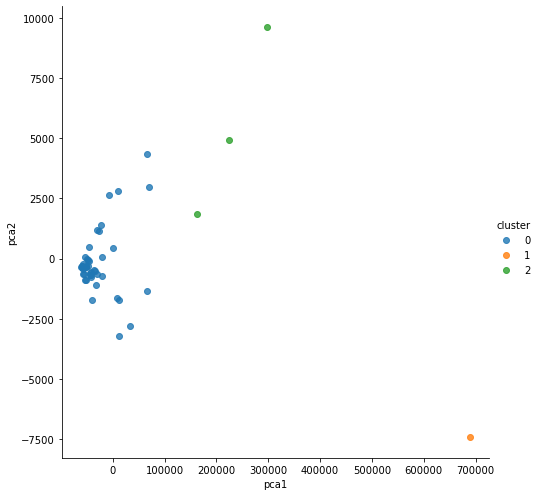

In [52]:
fig = sns.lmplot(x = 'pca1', y='pca2', data=kmeans_3, hue='cluster', fit_reg=False, height=7)
plt.show()

## Notice the Cluster that's all alone in the corner

Obj. Func: 223412351304.1622
Obj. Func: 63603736942.07282
Obj. Func: 22344251866.69509
Obj. Func: 15081978410.775639
Obj. Func: 7849814922.320096
Obj. Func: 4376994544.845112
Obj. Func: 2445566541.962015
Obj. Func: 1489096414.4696867
Obj. Func: 872176184.9965084


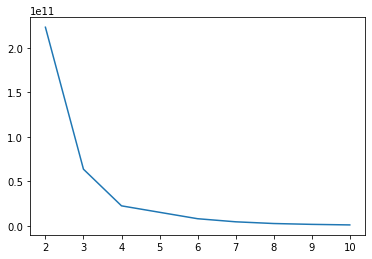

In [53]:
clusterRange = range(2,11)

objFuncs = []
for i in clusterRange:
    kmeans = KMeans(n_clusters=i).fit(norm_stats2018.values)
    # sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
    print("Obj. Func:", kmeans.inertia_)
    objFuncs.append(kmeans.inertia_)

plt.plot(clusterRange, objFuncs)

Text(0.5, 1.0, 'Silhouette Score vs Number of Clusters')

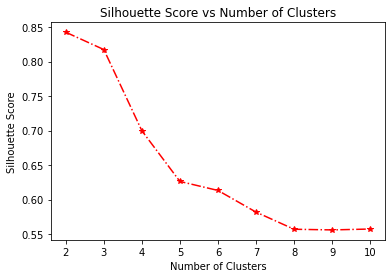

In [54]:
from sklearn.metrics import silhouette_score

ss= []

k_range=range(2,11)

#Fit the KMeans model for each n_clusters=k
k_means = [KMeans(n_clusters=k).fit(norm_stats2018.values) for k in k_range]
sscores = [silhouette_score(norm_stats2018.values, kmean.labels_) for kmean in k_means]

plt.plot(list(k_range), sscores, 'r*-.')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")

## Given the silhouette score and the elbow rule, it seems that 3 is a very appropriate number of clusters for the data without overfitting

So what can we deduce from the formed clusters?

In [55]:
#kmeans_3.index = population_states['Location']
kmeans_3['index']=kmeans_3.index
kmeans_3

,cluster,pca1,pca2,index
0,0,-21826.498316,1385.782064,0
1,0,-51803.724135,-908.199755,1
2,0,-41314.489749,-702.122850,2
3,0,-26115.196651,1131.587471,3
4,0,-45341.068243,-91.015580,4
5,0,-42804.982875,-570.436180,5
6,0,-44753.301370,-697.471555,6
7,0,-39700.670575,-1705.560456,7
8,1,689238.649783,-7423.531977,8
9,0,-49020.053104,-27.045884,9


In [60]:
kmeans_3.index= state_list
clusterResults2018 = pd.concat([kmeans_3, state_2018], axis=1, join='outer')
clusterResults2018.drop(columns='state')
clusterResults2018['Location'] = clusterResults2018['state']
clusterResults2018
#I had to do some janky stuff because of the index and columns...not sure how that keeps happening

,cluster,pca1,pca2,index,Year,Prscrbr_Geo_Lvl,Prscrbr_Geo_Cd,state,RUCA_Cd,Breakout_Type,...,LA_Opioid_Prscrbng_Rate,LA_Opioid_Prscrbng_Rate_5Y_Chg,LA_Opioid_Prscrbng_Rate_1Y_Chg,range_category,2018_age_adjusted_rate,2018_num_deaths,Normalized_Death_Rate,Normalized_Long-Acting_Rate,Normalized_Tot_Opioid_Clms,Location
state,,,,,,,,,,,,,,,,,,,,,
Alabama,0,-21826.498316,1385.782064,0,2018,State,1.0,Alabama,NaN,Totals,...,8.36,-1.36,-0.97,16.1 to 18.5,16.6,775,15.856190,3315.744215,39772.542172,Alabama
Alaska,0,-51803.724135,-908.199755,1,2018,State,2.0,Alaska,NaN,Totals,...,18.61,-0.96,-0.72,13.6 to 16.0,14.6,110,14.963157,1825.097022,9744.626200,Alaska
Arizona,0,-41314.489749,-702.122850,2,2018,State,4.0,Arizona,NaN,Totals,...,14.80,-1.44,-0.98,21.1 to 57.0,23.8,"1,670",23.330461,2938.590315,20176.623877,Arizona
Arkansas,0,-26115.196651,1131.587471,3,2018,State,5.0,Arkansas,NaN,Totals,...,8.56,-0.76,-0.95,13.6 to 16.0,15.7,444,14.752139,3029.072679,35485.890492,Arkansas
California,0,-45341.068243,-91.015580,4,2018,State,6.0,California,NaN,Totals,...,11.26,-0.67,-0.59,11.1 to 13.5,12.8,"5,348",13.552420,1826.373536,16258.750938,California
Colorado,0,-42804.982875,-570.436180,5,2018,State,8.0,Colorado,NaN,Totals,...,14.20,-2.17,-0.99,16.1 to 18.5,16.8,995,17.482865,2620.655047,18714.496110,Colorado
Connecticut,0,-44753.301370,-697.471555,6,2018,State,9.0,Connecticut,NaN,Totals,...,14.92,-2.03,-1.07,21.1 to 57.0,30.7,"1,069",29.931234,2501.931951,16765.636889,Connecticut
Delaware,0,-39700.670575,-1705.560456,7,2018,State,10.0,Delaware,NaN,Totals,...,19.28,0.19,-0.36,21.1 to 57.0,43.8,401,41.533788,4136.910280,21651.548928,Delaware
Florida,1,689238.649783,-7423.531977,8,2018,State,12.0,Florida,NaN,Totals,...,13.76,0.82,-0.19,21.1 to 57.0,22.8,"4,698",669.662902,101398.623328,744095.316489,Florida


In [61]:
clusterResults2018.groupby(["cluster", "Location"]).Normalized_Death_Rate.mean()

cluster  Location      
0        Alabama            15.856190
         Alaska             14.963157
         Arizona            23.330461
         Arkansas           14.752139
         California         13.552420
         Colorado           17.482865
         Connecticut        29.931234
         Delaware           41.533788
         Georgia             6.608826
         Hawaii              2.026423
         Idaho              17.598285
         Illinois          155.495231
         Indiana            12.803513
         Iowa                4.286463
         Kansas             10.957188
         Kentucky           45.167910
         Louisiana          25.553932
         Maine               7.403926
         Maryland          173.554972
         Massachusetts      37.128455
         Michigan           37.645466
         Minnesota           6.370146
         Mississippi         5.529544
         Missouri           54.008360
         Montana             2.041942
         Nebraska         

In [62]:
clusterResults2018.groupby(["cluster", "Location"]).Normalized_Tot_Opioid_Clms.mean()

cluster  Location      
0        Alabama            39772.542172
         Alaska              9744.626200
         Arizona            20176.623877
         Arkansas           35485.890492
         California         16258.750938
         Colorado           18714.496110
         Connecticut        16765.636889
         Delaware           21651.548928
         Georgia            12616.966360
         Hawaii              1400.964235
         Idaho              29685.487081
         Illinois          127863.353350
         Indiana            14425.892578
         Iowa               10086.889940
         Kansas             24387.834031
         Kentucky           54581.502916
         Louisiana          32100.448580
         Maine               6834.062725
         Maryland           72674.904766
         Massachusetts      19695.252286
         Michigan           41043.332382
         Minnesota           9362.802832
         Mississippi        16160.650925
         Missouri           61009

In [72]:
clusterResults2018.groupby(["cluster", "Location"]).min()

pca1         pca2  index  Year  \
cluster Location                                                  
0       Alabama         -21826.498316  1385.782064      0  2018   
        Alaska          -51803.724135  -908.199755      1  2018   
        Arizona         -41314.489749  -702.122850      2  2018   
        Arkansas        -26115.196651  1131.587471      3  2018   
        California      -45341.068243   -91.015580      4  2018   
        Colorado        -42804.982875  -570.436180      5  2018   
        Connecticut     -44753.301370  -697.471555      6  2018   
        Delaware        -39700.670575 -1705.560456      7  2018   
        Georgia         -49020.053104   -27.045884      9  2018   
        Hawaii          -60288.114174  -323.405881     10  2018   
        Idaho           -31682.231255 -1076.789392     11  2018   
        Illinois         66593.282290  4345.461094     12  2018   
        Indiana         -47193.825979   -49.496296     13  2018   
        Iowa            -51532.235086  -327.922254     14  2018   
        Kansas          -37096.434950  -490.721660     15  2018   
        Kentucky         -7059.378473  2650.416314     16  2018   
        Louisiana       -29535.250868  1191.490420     17  2018   
        Maine           -54773.604255  -623.498553     18  2018   
        Maryland         11921.128831 -3211.338801     19  2018   
        Massachusetts   -41789.747966  -780.594194     20  2018   
        Michigan        -20378.056014    63.491245     21  2018   
        Minnesota       -52260.242103  -342.613685     22  2018   
        Mississippi     -45511.999847   477.760531     23  2018   
        Missouri          -298.187859   426.450186     24  2018   
        Montana         -57561.522521  -398.842228     25  2018   
        Nebraska        -21748.741579  -723.812397     26  2018   
        Nevada          -29877.118986  -626.770062     27  2018   
        New Hampshire   -52986.758503  -905.401898     28  2018   
        New Jersey       32875.033517 -2804.126054     29  2018   
        New Mexico      -57166.318277  -213.631018     30  2018   
        New York         66269.773649 -1336.583821     31  2018   
        North Carolina  -47178.888401  -317.432848     32  2018   
        North Dakota    -60358.433975  -338.294051     33  2018   
        Oklahoma        -51405.533910  -367.553849     35  2018   
        Oregon          -35217.628960  -496.019272     36  2018   
        Pennsylvania     11622.924669 -1737.568534     37  2018   
        Rhode Island    -60251.540647  -293.969104     38  2018   
        South Carolina   69666.595866  2993.199971     39  2018   
        South Dakota    -57868.750534  -427.432987     40  2018   
        Texas            10522.381751  2788.663649     42  2018   
        Utah            -59783.435599  -341.666391     43  2018   
        Vermont         -57848.813482  -629.506865     44  2018   
        Washington      -44292.513499  -615.131188     46  2018   
        West Virginia   -54268.430755    52.205199     47  2018   
        Wisconsin         7702.913688 -1619.627436     48  2018   
        Wyoming         -59963.074500  -353.751793     49  2018   
1       Florida         689238.649783 -7423.531977      8  2018   
2       Ohio            297126.507423  9623.664638     34  2018   
        Tennessee       224196.063016  4933.608969     41  2018   
        Virginia        162121.543490  1835.104999     45  2018   

                       Prscrbr_Geo_Lvl  Prscrbr_Geo_Cd           state  \
cluster Location                                                         
0       Alabama                  State             1.0         Alabama   
        Alaska                   State             2.0          Alaska   
        Arizona                  State             4.0         Arizona   
        Arkansas                 State             5.0        Arkansas   
        California               State             6.0      California   
        Colorado              

# Conclusions Based on the Clustering Results

    1. Death may be more likely if in states Ohio, Tennessee, and Virginia
    2. Hihgly likely if in Florida
    3. Total Opioid Claims notably higher in Ohio, Tennessee, and Virginia
    4. Total Opioid Claims dramatically higher in Florids

In [84]:
#Below I've parsed information to show a visual representation of how many deaths there were per state in 2019 
clusterResults2018['Location'] = clusterResults2018['Location'].astype(str)
clusterResults2018 = clusterResults2018.replace(',', '', regex=True)
clusterResults2018['2018_num_deaths'] = clusterResults2018['2018_num_deaths'].astype(int)
.replace(',', '')
sns.set(rc={"figure.figsize":(20, 6)})
odBSBar = sns.barplot(data=clusterResults2018, x='Location', y='2018_num_deaths')
odBSBar.set_xticklabels(labels=overdoseByState['Location'], rotation=90)

SyntaxError: invalid syntax (586651323.py, line 5)